# 09. 선형적으로 분리되는 데이터셋에 Linear SVC를 적용해보세요. 그런다음 같은 데이터셋에  SVC와 SGDClassifier를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요

In [124]:
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [125]:
iris = load_iris(as_frame=True)
data = iris.data[['sepal length (cm)', 'sepal width (cm)']].values
target = iris.target

X, y = data[(target == 0) | (target == 1)], target[(target == 0) | (target == 1)]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [126]:
target.unique()

array([0, 1, 2])

In [127]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [128]:
models = {
    'LinearSVC': LinearSVC(random_state=42),
    'SVC': SVC(kernel='linear', random_state=42),
    'SGDClf': SGDClassifier(random_state=42, penalty=None),
}

w1*x1 + w2*x2 + b = 0

x2 = -(w1/w2)*x1 - b

In [129]:
# X1의 최소/최대값 구하기
min_sepal_length, max_sepal_length = X_scaled[:, 0].min(), X_scaled[:, 0].max()

def draw_decision_boundary(clf):
    w1, w2 = clf.coef_[0]
    b = clf.intercept_[0]
    points = [
        [min_sepal_length, -min_sepal_length * (w1/w2) + b],
        [max_sepal_length, -max_sepal_length * (w1/w2) + b]
    ]
    return scaler.inverse_transform(points)

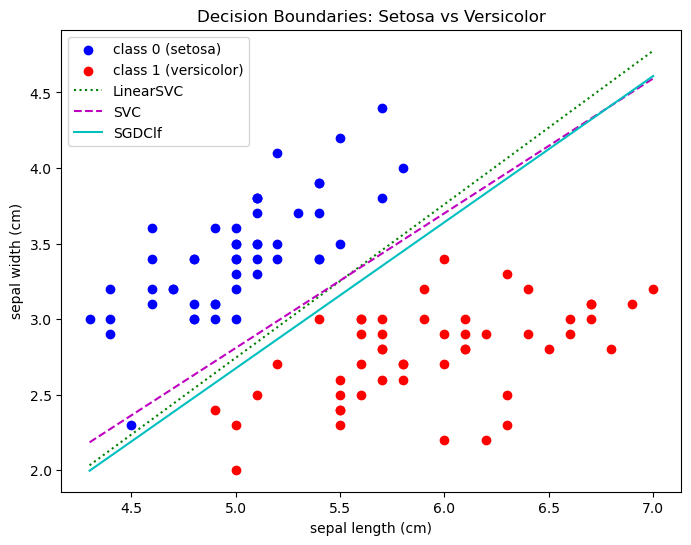

In [130]:
plt.figure(figsize=(8,6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='b', label="class 0 (setosa)")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='r', label="class 1 (versicolor)")

line_shapes = ['g:', 'm--', 'c-']

for (name, model), ls in zip(models.items(), line_shapes):
    clf = model.fit(X_scaled, y)
    boundary = draw_decision_boundary(clf)
    plt.plot(boundary[:, 0], boundary[:, 1], ls, label=name)

plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.title("Decision Boundaries: Setosa vs Versicolor")
plt.legend()
plt.show()

# 10. load_wine() 데이터 사용해서 재배자 분류 수행

In [143]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [134]:
wine = load_wine(as_frame=True)
data = wine.data.values
target = wine.target

In [191]:
wine.data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=42)

In [164]:
linsvc = Pipeline([
    ('scaler', StandardScaler()), 
    ('LinearSVC', LinearSVC(random_state=42)),
])

linsvc.fit(X_train, y_train)

cross_val_score(linsvc, X_train, y_train).mean()

np.float64(0.9774928774928775)

In [173]:
svc = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVC', SVC(random_state=42)),
])

svc.fit(X_train, y_train)

cross_val_score(svc, X_train, y_train).mean()

np.float64(0.9698005698005698)

In [178]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

search_space = {
    'SVC__gamma': loguniform(0.01, 0.1),
    'SVC__C': uniform(1, 10)
    
}

rnd_search_cv = RandomizedSearchCV(
    svc, 
    search_space,
    n_iter=50,
    cv=5,
    random_state=42,
)

rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

,steps,"[('scaler', ...), ('SVC', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,np.float64(8.712703466859457)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....8906685575274)


In [192]:
rnd_search_cv.best_score_

np.float64(0.9925925925925926)

In [180]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

In [184]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np

In [185]:
space = {
    'C': hp.uniform('C', 1, 11),           # uniform(1, 10)
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(0.1)),  # loguniform(0.01, 0.1)
}

In [186]:
# 목적 함수 정의
def objective(params):
    # pipeline 생성
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**params))
    ])
    
    # 5-fold 교차검증 정확도
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    # hyperopt는 loss 최소화를 목표로 하기 때문에 1-accuracy 사용
    return {'loss': 1 - score, 'status': STATUS_OK}

# 탐색 기록용 Trials 객체
trials = Trials()

# 최적화 실행 (TPE 알고리즘 사용)
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|████████████████████████████████████████████| 500/500 [00:05<00:00, 83.97trial/s, best loss: 0.007407407407407418]


In [187]:
best

{'C': np.float64(9.300896323724805), 'gamma': np.float64(0.011595430129354971)}

In [188]:
# 최적 파라미터로 모델 생성
best_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        C=best['C'],
        gamma=best['gamma'],
        kernel='rbf'
    ))
])

# 학습
best_clf.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,np.float64(9.300896323724805)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....5430129354971)


In [190]:
cv_score = cross_val_score(best_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Best cross-validation score:", cv_score)

test_score = best_clf.score(X_test, y_test)
print("Test set score:", test_score)

Best cross-validation score: 0.9925925925925926
Test set score: 0.9777777777777777
